In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt

from logger import Logger
from collector import Collector
from enricher import Enricher

sns.set(style='darkgrid')


In [26]:
logger = Logger()
collector = Collector(logger=logger)
enricher = Enricher(logger=logger)

df_raw = collector.collector_data()
df = enricher.calcular_kpi(df_raw)


In [27]:
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df = df.dropna(subset=['fecha', 'cerrar'])
df = df.set_index('fecha').sort_index()
df.tail()


,abrir,max,min,cerrar,cierre_ajustado,volumen,volatilidad,tasa_variacion,media_movil_7d,retorno_acumulado,desviacion_total
fecha,,,,,,,,,,,
2023-01-05,827.87,859.96,818.01,856.09,856.09,415.2,15.661231,0.022270,846.575714,28.691407,233.032369
2023-01-06,856.09,879.42,847.01,873.47,873.47,343.0,18.082227,0.020302,849.314286,29.294190,233.032369
2023-01-09,891.26,920.00,882.00,897.31,897.31,451.8,28.407286,0.027293,857.562857,30.121023,233.032369
2023-01-10,897.00,919.19,896.31,915.78,915.78,270.2,31.329880,0.020584,864.634286,30.761610,233.032369
2023-01-11,928.29,936.89,911.10,936.80,936.80,466.1,32.241096,0.022953,877.571429,31.490638,233.032369


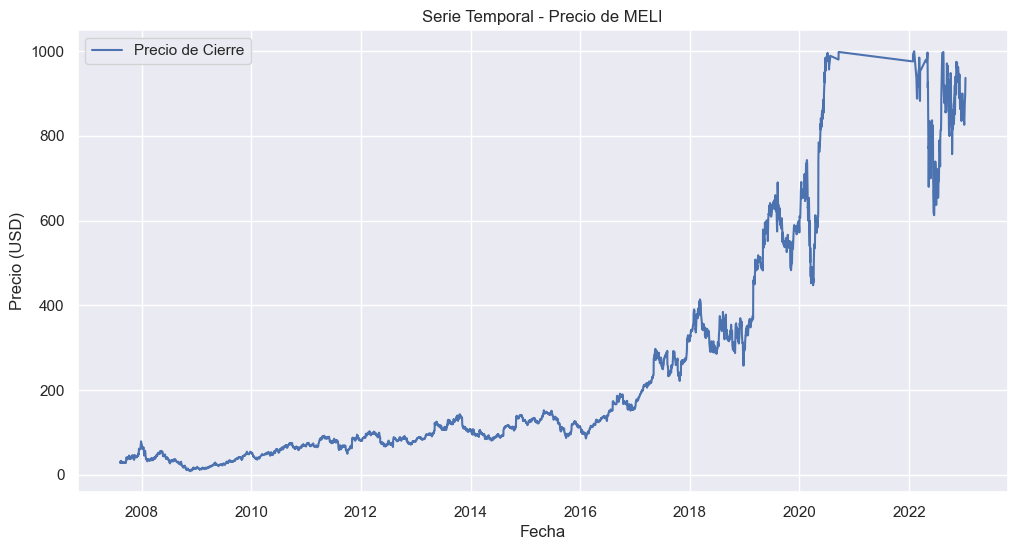

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cerrar'], label='Precio de Cierre')
plt.title('Serie Temporal - Precio de MELI')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()


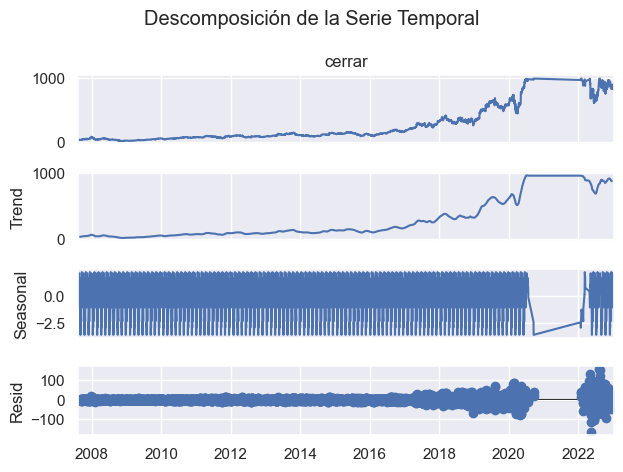

In [29]:
resultado = sm.tsa.seasonal_decompose(df['cerrar'], model='additive', period=30)
resultado.plot()
plt.suptitle('Descomposición de la Serie Temporal')
plt.tight_layout()
plt.show()


In [30]:
adf_result = adfuller(df['cerrar'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: 0.33739236741977685
p-value: 0.9789964670233128
Critical Values:
   1%: -3.4322691288597564
   5%: -2.8623879604356635
   10%: -2.5672213852650048


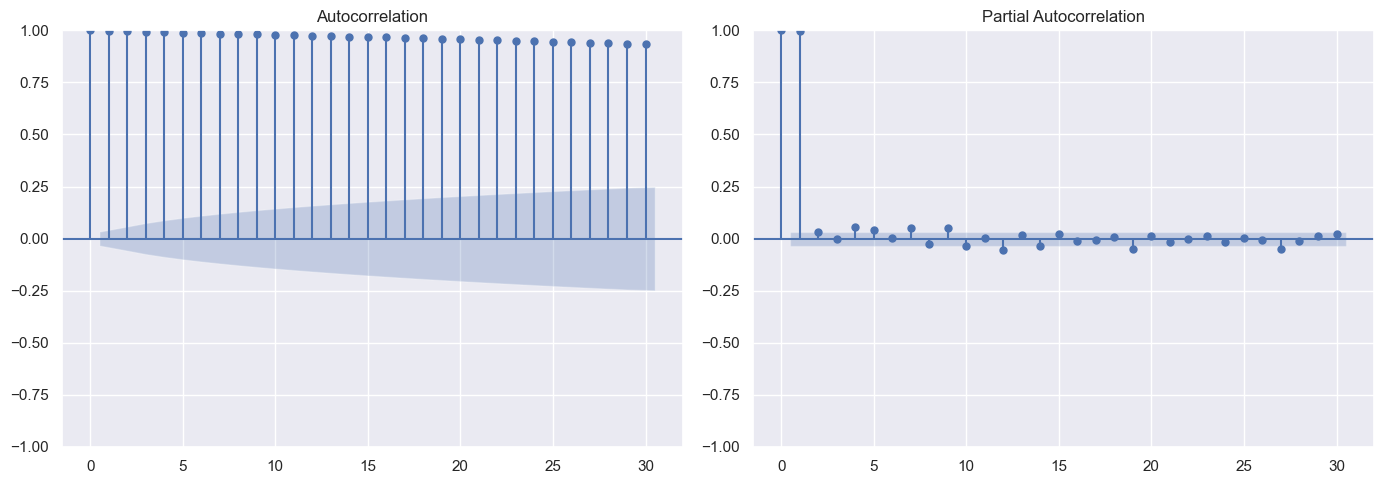

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plot_acf(df['cerrar'], ax=plt.gca(), lags=30)
plt.subplot(1,2,2)
plot_pacf(df['cerrar'], ax=plt.gca(), lags=30)
plt.tight_layout()
plt.show()


C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

                               SARIMAX Results                                
Dep. Variable:                 cerrar   No. Observations:                 3436
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -13233.616
Date:                Sun, 25 May 2025   AIC                          26479.232
Time:                        13:37:00   BIC                          26516.083
Sample:                             0   HQIC                         26492.396
                               - 3436                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0430      0.006     -6.692      0.000      -0.056      -0.030
ar.L2          0.0339      0.005      6.532      0.000       0.024       0.044
ar.L3         -0.0925      0.007    -14.103      0.0

C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


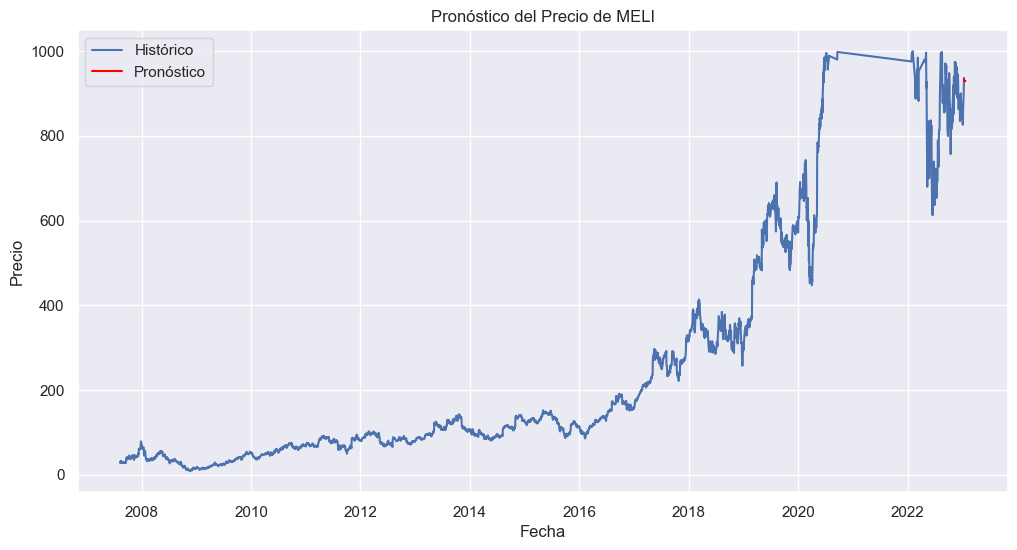

In [32]:
from statsmodels.tsa.arima.model import ARIMA

modelo = ARIMA(df['cerrar'], order=(5,1,0))
modelo_fit = modelo.fit()
print(modelo_fit.summary())

forecast = modelo_fit.forecast(steps=10)
plt.figure(figsize=(12,6))
plt.plot(df['cerrar'], label='Histórico')
plt.plot(pd.date_range(df.index[-1], periods=11, freq='D')[1:], forecast, label='Pronóstico', color='red')
plt.legend()
plt.title('Pronóstico del Precio de MELI')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()


C:\Users\jamsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


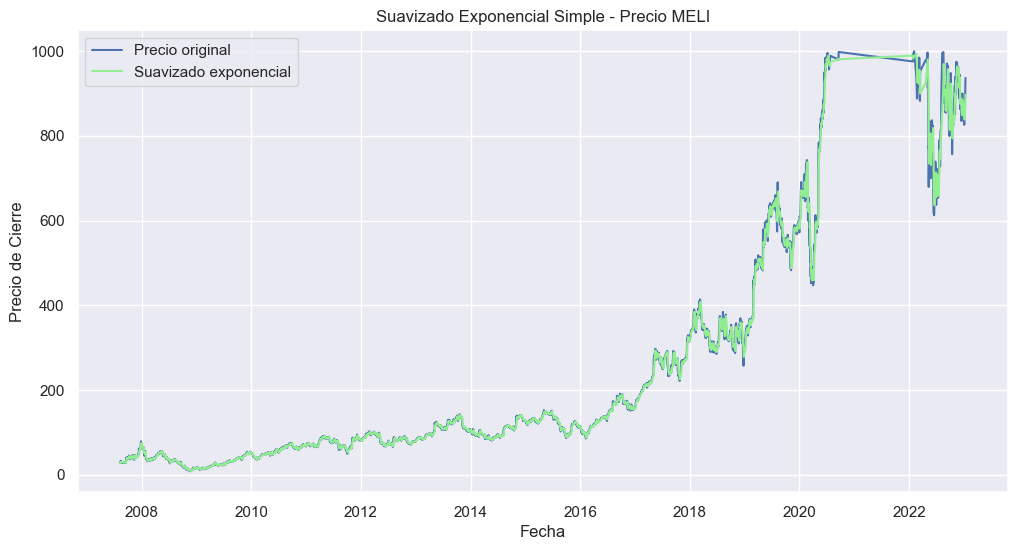

In [45]:

df_enriched['fecha'] = pd.to_datetime(df_enriched['fecha'], errors='coerce')
df_enriched = df_enriched.dropna(subset=['fecha', 'cerrar'])
df_enriched = df_enriched.sort_values('fecha')


serie = df_enriched.set_index('fecha')['cerrar']

model_ses = SimpleExpSmoothing(serie).fit(smoothing_level=0.5, optimized=False)
ses_result = model_ses.fittedvalues

df_ses = serie.to_frame().copy()
df_ses['SES'] = ses_result

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(df_ses['cerrar'], label='Precio original')
plt.plot(df_ses['SES'], label='Suavizado exponencial', color='lightgreen')
plt.title('Suavizado Exponencial Simple - Precio MELI')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()


